# Planning: State Spaces and Search

A common problem in robotics and control is **path planning**. In EECS16B, we studied controllable systems from a linear-algebraic perspective. Our state variables (angle, position, etc) would be represented by a vector, and the system would be represented by matrix transformation. We used this linear system perspective as a means of controlling our robot car. 

Once we have a robot under control, the next thing we want to do in a variety of scenarios is to **plan** out the path that our robot car should take to accomplish a certain task. In order to do so, we'll need to reconsider how we think about our "state"—rather than view a state as a vector which can take on continuous values, we will instead define a set of discrete values that our variables can take on and consider the state as a node in a graph. 

You'll recall from EECS16B that given a continuous-time system, we can sample or discretize in the time dimension and model some scenarios with a discrete-time system. Graph state-space models take another step of also discretizing in the *spatial* dimensions to have a finite number of possible states.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

## State Spaces - Defining the Robot's configuration in the Environment

Path Planning is a large field in Robotic Manipulation. The approach taken here, using graph searches, builds off the foundations laid by Artificial Intelligence researchers in the 1960s-70s. The key idea is that if we can treat an entire configuration as a node on a graph, then we search on our graph for possible paths and try to find a state that is in the desired configuration.

First, let's define some basics.

A **state** encodes all the necessary information about the configuration of the robot, and is represented by a node in our search graph. 

**Successors** of a state are possible next states that our robot can advance to. In our graph, this means there is an edge from the node for this state to the next one. The edge represents what we call a **transition** from one state to another. 

**Cost**: Moving from one edge to another may incur some kind of penalty on the agent. For example, a robot with a finite amount of energy may lose some of that energy when making a transition. We call this the "cost" to the agent and represent it as a weight along the edge associated with the transition.

**Goal Test** Some states are in desired final configuration. We can perform a goal test to see if a state is in a desired configuration. 


Look at the code below for an abstract base class that represents any state. A state would have some object attributes, and a function to generate the successors of the state.

In [ ]:
# abstract base class for State 
class State: 
    
    def __init__(self):
        pass
        
    def getNextStates(self):
        '''getNextStates(self) --> list(tuple(State, int)) 
        Returns a list of next states and the cost associated with them. 
        The output should be in the form [(state, cost), (state, cost), ... ]'''
        pass
    
    

Let's consider a robot that looks like this.  

(Image source: https://www.istockphoto.com/photo/industrial-robot-arm-isolated-on-a-white-background-gm509660417-46593632). 

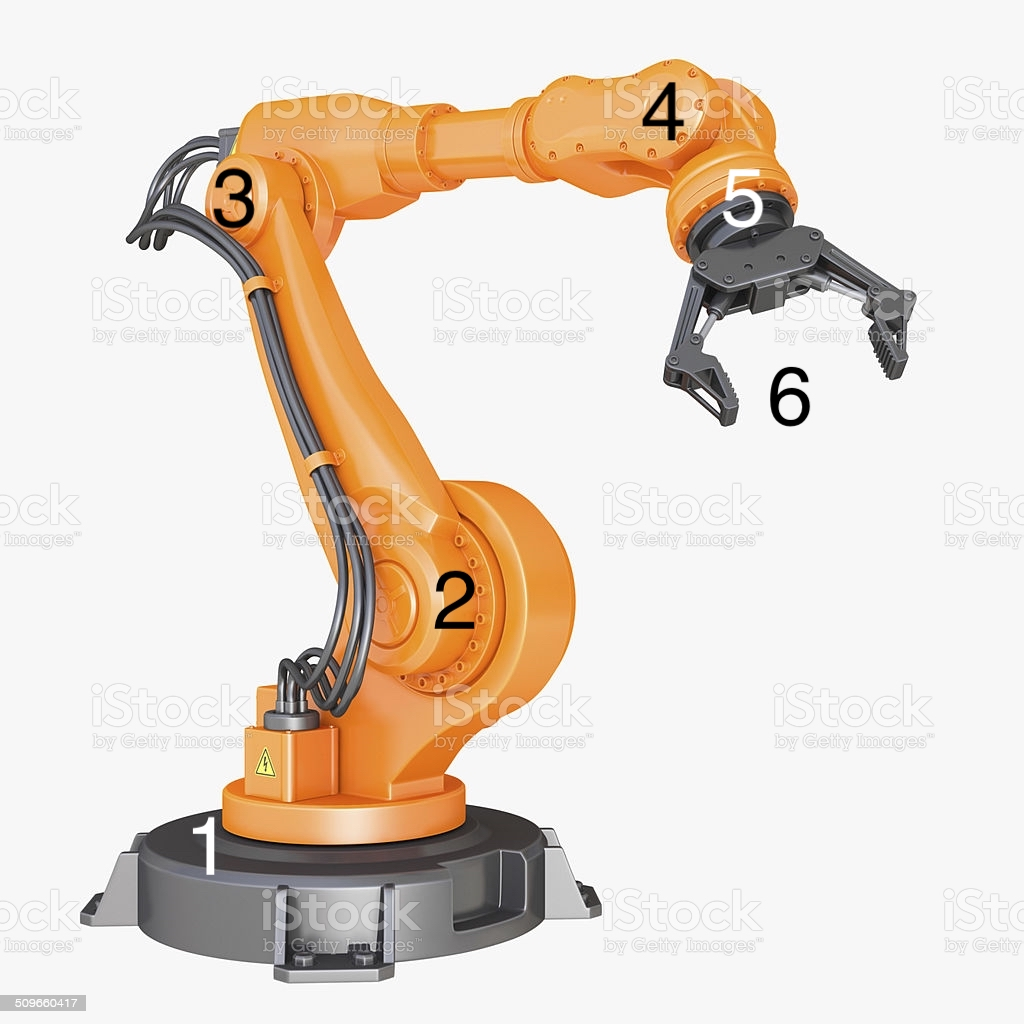

There are 6 Degrees Of Freedom (DOF) in this robot: 

1. Base. The robot can swivel the arm around its base. This can take on any value from 0 to 360 degrees in multiples of 30 degrees (ie. 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330). 
2. Shoulder. We can rotate about this joint to raise or lower the entire arm. This can take any value in (-90, -45, 0, 45, 90), where -90 means the arm is flat on the table backwards, 0 means the arm is perpendicular to the table. and 90 means the arm is flat on the table forwards.
3. Elbow. We can use this to raise or lower the forearm. This can take on any value from -180 to 180 degrees in multiples of 15 degrees (ie. -180, -165, -150, -135, -120, -105, -90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165) Notice that -180 degrees equals 180 degrees. 
4. Wrist. We can move the grasper up and down. This can take on any value in 0 to 90 degrees, in multiples of 10 (ie. 0, 10, 20, 30, 40, 50, 60, 70, 80, 90) where 0 is parallel to the forearm, and 90 is perpendicular to the forearm. 
5. Swivel. We can swivel the grasper in any angle from 0 to 360 in multiples of 30 degrees (0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330)
6. Grasper. Our grasper can be in an open or closed position.  

Notice the corresponding labels on the robot above. For simplicity, let's ignore any self-collisions we may encounter with this robot.  

We'll notice that there are a total of $12 * 5 * 24 * 10 * 12 * 2 = 345600$ different possible unique configurations of the robot.



### Task 1: Encode the robot state! 

Your task now is to create a subclass of State that encodes the configuration of the 6DOF robot. Note that in our transition from one state to the next, we can only change *one joint at a time*. Also, we can only change a joint by one "tick" in either direction, ie. if our angle is only allowed to be a multiple of 30, we can either increase or decrease that angle by 30 degrees. Note that we also may not do anything at all (stay in the same position). 

Note that for the base, elbow, and swivel joints, we are allowed to keep moving in a circle (ie. 360 degrees = 0 degrees, and -180 degrees = 180 degrees). For the shoulder and wrist joints, at the endpoints of the motion domain (-90 and 90 for shoulder, 0 and 90 for wrist), we only have one possible way we could move. 

For any given state, there are up to a total of $12$ possible valid moves (May be less if at endpoint of domain for wrist or shoulder).  

Let's code it up! For the time being, let all the edge costs be 1.

Hint: Remember, 390 degrees = 30 degrees, and -30 degrees = 330 degrees

In [ ]:
class MyRobotState(State):
    def __init__(self, base=0, shoulder=90, elbow=-180, wrist=90, swivel=0, grasper='open'):
        assert (0 <=  base < 360 and base % 30 == 0), "invalid base angle"
        assert (-90 <= shoulder <= 90 and shoulder % 45 == 0), "invalid shoulder angle"
        assert (-180 <= elbow < 180 and elbow % 15 == 0), "invalid elbow angle"
        assert (0 <= wrist <= 90 and wrist % 10 == 0), "invalid wrist angle"
        assert (0 <= swivel < 360 and swivel % 30 == 0), "invalid swivel angle"
        assert (grasper in ('open', 'closed')), "invalid grasper value"

        # Your code here: assign state variables (attributes) 
        
        
    def __str__(self):
        return "MyRobotState:\n  Base = {0}\n  Shoulder = {1}\n  Elbow = {2}\n  Wrist = {3}\n  Swivel = {4}\n  Grasper = {5}\n".format(
            self.base, self.shoulder, self.elbow, self.wrist, self.swivel, self.grasper
        )

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        if not isinstance(other, MyRobotState): return False
        return self.base == other.base and self.shoulder == other.shoulder and \
          self.elbow == other.elbow and self.wrist == other.wrist and \
          self.swivel == other.swivel and self.grasper == other.grasper

    def __hash__(self):
        h = (self.base // 30) * 1e10 + (2 + self.shoulder // 45) * 1e8 +  (12 + self.elbow // 15) * 1e6 + (self.wrist // 10) * 1e4 + (self.swivel // 30) * 1e2 + (1 if self.grasper == 'open' else 0)
        return int(h)

    def getNextStates(self):
        pass
        # YOUR CODE HERE


## Task 2: Building Search Trees 

Let's consider a generic graph now. While tracing out these search trees, you should think that each node is a state representing a robot's configuration, and that each edge represents an action whe could take. So a completed route to a node is a sequence of actions to a desired final configuration. 

On a separate sheet of paper, draw out the DFS search tree, the BFS search Tree, and the UCS shortest paths tree for the following graphs, starting at the node labelled "A" and searching until all nodes have been visited. Break ties alphabetically. Note that you will not consider the edge weights for BFS and DFS, only for UCS. 

(Source: https://cs.lmu.edu/~ray/notes/graphalgorithms/)





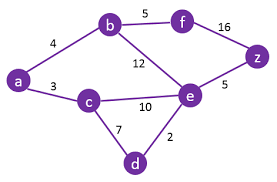

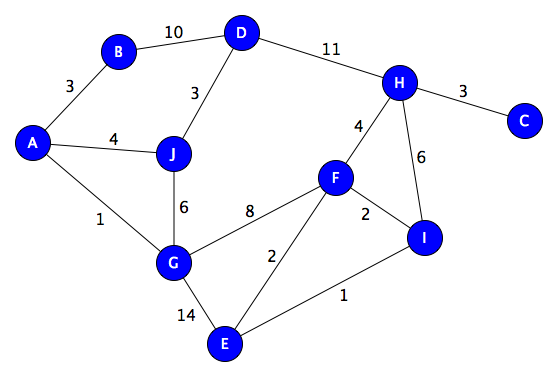

In [ ]:
class PurpleState(State):
    def __init__(self, label='a'):
        self.label = label
    def __hash__(self):
        return ord(self.label)
    def __eq__(self, other):
        return self.label == other.label
    def __str__(self):
        return 'State ' + self.label
    def __repr__(self):
        return 'State ' + self.label
    def getNextStates(self):
        return {'a': [(PurpleState('b'), 4), (PurpleState('c'), 3)],
                'b': [(PurpleState('a'), 4), (PurpleState('e'), 12), (PurpleState('f'), 5)],
                'c': [(PurpleState('a'), 3), (PurpleState('d'), 7), (PurpleState('e'), 10)],
                'd': [(PurpleState('c'), 7), (PurpleState('e'), 2)],
                'e': [(PurpleState('b'), 12), (PurpleState('c'), 10), (PurpleState('d'), 2), (PurpleState('z'), 5)],
                'f': [(PurpleState('b'), 5), (PurpleState('z'), 16)],
                'z': [(PurpleState('f'), 16), (PurpleState('e'), 5)],
              }[self.label]

class BlueState(State):
    def __init__(self, label='a'):
        self.label = label
    def __hash__(self):
        return ord(self.label)
    def __eq__(self, other):
        return self.label == other.label
    def __str__(self):
        return 'State ' + self.label
    def __repr__(self):
        return 'State ' + self.label
    def getNextStates(self):
        return {'a': [(BlueState('b'), 3), (BlueState('g'), 1), (BlueState('j'), 4)],
                'b': [(BlueState('a'), 3), (BlueState('d'), 10)],
                'c': [(BlueState('h'), 3)],
                'd': [(BlueState('b'), 10), (BlueState('h'), 11), (BlueState('j'), 3) ],
                'e': [(BlueState('f'), 2), (BlueState('g'), 14), (BlueState('i'), 1)],
                'f': [(BlueState('e'), 2), (BlueState('g'), 8), (BlueState('h'), 4), (BlueState('i'), 2)],
                'g': [(BlueState('a'), 1), (BlueState('e'), 14), (BlueState('f'), 8), (BlueState('j'), 6)],
                'h': [(BlueState('c'), 3), (BlueState('d'), 11), (BlueState('f'), 4), (BlueState('i'), 6)],
                'i': [(BlueState('e'), 1), (BlueState('f'), 2), (BlueState('h'), 6)],
                'j': [(BlueState('a'), 4), (BlueState('d'), 3), (BlueState('g'), 6)],
              }[self.label]
  

The code above creates our state space abstractions for the graphs provided. (Note that a lot of stuff is hardcoded—this is bad practice, not something you should typically be doing for state-space search problems.)

## Graph Search vs Tree Search

While tree search may get stuck in cycles visiting the same few states over and over again, graph search avoids this problem by holding onto a "seen" set of nodes that we have already encountered. 

## Solving Search Problems - Uninformed Search

Unlike the graph search algorithms you may have seen in a class like CS 61B, the search algorithms here generate the graph "on demand", ie. when it is asked for, rather than store the whole graph from the beginning.

Before we code up the searches, let's create a goal test function that we will use for the MyRobotState configuration problem.

### Task 3: Goal test function

Let's say our goal is for the robot to have it's **arm fully extended up (perpendicular to the table). The pincers should be rotated by 60 degrees about the vertical axis, and all the joints should be fully straight up. The pincers should be open**. Write an a goal test function for this objective.

In [ ]:
def robotGoalTest(state):
    assert isinstance(state, MyRobotState), "input must be a MyRobotState"
    # YOUR CODE HERE

### Task 4: Utility Classes

Look over the following classes that are provided for you. For each of them, identify the strategy that we are using to remove nodes. 

Optional: We have provided a slow PriorityQueue class for you.  If you want an extra challenge, try implementing a more efficient PriorityQueue using a heap (more details in the docstring)

In [ ]:
import queue

class Stack:
    def __init__(self, startingitems=[]):
        self.lst = startingitems
    def push(self, item):
        self.lst.append(item)
    def pop(self):
        return self.lst.pop()
    def isEmpty(self):
        return len(self.lst) == 0


class Queue:
    def __init__(self, startingitems=[]):
        self.q = queue.Queue()
        for item in startingitems:
          self.q.put(item)
    def push(self, item):
        self.q.put(item)
    def pop(self):
        if self.q.qsize() == 0: raise IndexError("pop from empty list")
        return self.q.get()
    def isEmpty(self):
        return self.q.qsize() == 0

class PriorityQueue:
    '''A slow priority Queue class is provided.
    As a challenge, try re-implementing a more efficient priority queue.
    pop should remove the item with the lowest priority and return it.
    push should add an item to the queue if it is not already there. If it is already there,
    You should use a min-heap here so that the pop function is quick. Review your 61B notes
    if you need a reminder on how bubbling elements up and down in a min-heap works.
    To avoid a linear scan over all the elements when looking for an item for changePriority,
    you should also include hashmap from an item to its position in the heap.
    You may find it helpful to implement bubble_up() and bubble_down() helper functions.
    '''
    def __init__(self):
        self.pairs = []

    def push(self, item, priority):
        '''Changes priority if it is already present'''
        for i in range(len(self.pairs)):
            if self.pairs[i][0] == item:
                self.pairs[i][1] = priority
                return
        self.pairs.append( [item, priority] )

    def peek(self):
        return min(self.pairs, key=lambda pair: pair[1])

    def pop(self):
        p = self.peek()
        self.pairs.remove(p)
        return p

    def isEmpty(self):
        return len(self.pairs) == 0 

### Depth First Search (DFS)

DFS is the simplest graph search algorithm. It is so simple, in fact, that even the ancient Greeks discovered it! If you look at the story of Theseus, he had to explore the labyrinth to find a Minotaur. His wife told him to carry a piece of chalk, and also to unravel a string behind him as he went. When he visited a room or an intersection, he should mark it with the chalk. Theseus would release the string as he walked, and his wife held onto the other end of the string outside the labyrinth, so that when Theseus needed to backtrack his steps, he could follow the string. 

This story is a direct analog for depth-first seach of the maze. The string represents the stack (or recursive stack), as it allows us to backtrack up to where we came from. The chalk is like the "seen" set, since we mark the intersections with chalk to avoid exploring the same place multiple times. 

### Task 5: Let's code up DFS. 

Note that the Depth first search algorithm we want to implement is not as simple as just visiting the node and then calling DFS on all the children. This problem is asking us to return the full path we would follow to get to the goal state. So, we will need to have some way of holding onto the states we have seen already along the path (there are several approaches, like using a list of backpointers, or holding onto the path to each state and using that). 

In [ ]:
def dfs(state, goalTest): 
    '''dfs(State, func) --> list
    Performs a depth first search on the graph until we find a path to the goal state.
    Returns the path to the goal state that we find, represented by a list of nodes (States)
    that we pass through in reaching the goal.
    
    HINT - note that stack is last-in, first out. 
    State.getNextStates() returns the next states in alphabetical order
    We want our DFS to explore nodes higher in the alphabet FIRST
    For example, we would explore "b" before "c".
    You may need to reverse the list of successors that getNextStates() returns to you.'''
    # YOUR CODE HERE

In [ ]:
# test cases
print(dfs(PurpleState('a'), lambda state: state.label == 'z'))
print(dfs(BlueState('a'), lambda state: state.label == 'e'))

None
None


If you've done the previous part correctly, you should get `[State a, State b, State e, State z]` for DFS on PurpleState from a to z

And `[State a, State b, State d, State h, State f, State e]` for DFS on BlueState from a to e.

### Breadth First Search (BFS)
Instead of diving in a bad direction and getting lead astray or down a longer path like DFS may end up doing, we instead could expand outwards from the source, looking at nodes that are one edge away from the start, then two edges away, then three edges away, so on. This way, we end up with a path with the least number of edges.


### Task 6: Code up BFS.

In DFS, we needed to use a Stack data structure (or the recursive stack) to hold onto our fringe. For BFS, use a Queue, so that we have the first in, first out behavior of nodes on the fringe.

In [ ]:
def bfs(state, goalTest): 
    '''bfs(State, func) --> list(State)
    Performs a breadth first search on the graph until we find a path to a goal state.
    Returns the path to the goal state that we find, represented by a list of nodes (States)
    that we pass through in reaching the goal.'''
    # YOUR CODE HERE

In [ ]:
# Test your code. Compare the outputs to the predictions from the trees you drew in task 2. 
print(bfs(PurpleState('a'), lambda state: state.label == 'z'))
print(bfs(BlueState('a'), lambda state: state.label == 'e'))

None
None


If you've done the previous part correctly, you should get `[State a, State b, State e, State z]` for BFS on PurpleState from a to z

And `[State a, State g, State e]` for BFS on BlueState from a to e.

### Uniform Cost Search (UCS)

Uniform cost search now takes into account the weight of each edge, and expands the closest nodes to the source first. It ends up being an algorithm that always finds the shortest path to a goal state. 

### Task 7: Code up UCS.

You'll notice that UCS looks similar to Dijkstra's algorithm that you may have seen in a class like CS 61B. The main difference is that UCS generates the graph on demand, only adding nodes to the PriorityQueue when they are encountered, while Dijkstra's starts off with all our nodes in the PQ at a distance of infinity. 

In [ ]:
def ucs(state, goalTest):
    '''ucs(State, func) --> list(State)
    Performs a uniform cost search on the graph until we find a path to a goal state.
    Returns the path to the goal state that we find, represented by a list of nodes (States)
    that we pass through in reaching the goal.'''
    # YOUR CODE HERE

In [ ]:
# Test your code. Compare the outputs to the predictions from the trees you drew in task 2. 
# Feel free to tweak the goal tests 
print(ucs(PurpleState('a'), lambda state: state.label == 'z'))
print(ucs(BlueState('a'), lambda state: state.label == 'e'))

None
None


If you've done the previous part correctly, you should get `[State a, State c, State d, State e, State z]` for UCS on PurpleState from a to z

And `[State a, State g, State f, State e]` for UCS on BlueState from a to e.

## Can we do better? 

You'll realize that in many of these search algorithms, we are expanding way more nodes than we need to. For example, in UCS we generate a path tree looking in all directions, when in reality it may be beneficial to just look in one direction if we know the goal state is in that general direction.

Let's think about ways we can improve our search. 

### Task 8: Brainstorm ways to make our search more "intelligent".

Come up with a list of at least 3 ideas for ways that we can improve our search algorithm. Remember, the only metrics for success of our algorithm are whether we find the closest goal state or not, and how quickly we are able to do so.  Think outside the box! You don't need to stick with just the things that we are giving you.  For each of these ideas, identify if they require any additional information. 

### Some extra information: a heuristic

A heuristic is an estimated forward cost to the goal. In your brainstorm, you may have come up with the idea that if we could know how close we are to a given state, then we could accordingly prioritize exploring the states that are seemingly closer to the goal. 

Some terminology:  
An **admissible** heuristic is always an underestimate of the true forward cost from a node to the goal for any state.  
A **consistent** heuristic is admissible, and it also underestimates the "arc cost" of every edge on the graph. That is, the difference in the heuristic values across an edge in the graph is less than the true weight across the edge in the graph. 

Heuristics require extra information about the environment. Accordingly, search which requires heuristics is called "informed search". 

## Informed Search 

As mentioned, informed search makes use of heuristics along each step of the way in order to find a solution faster! The main intution is that if we know some additional information about the environment, we can use that to choose what states to explore first. 

Run the cell below to generate a heuristic function for the purple and blue graphs above. Note that this heuristic is admissible. 

*Note that `purpleHeuristic` is for state **z** being the goal state, and the `blueHeuristic` is for state **c** being the goal state.*


In [ ]:
def purpleHeuristic(state):
    return {
      'a': 15,
      'b': 13,
      'c': 12,
      'd': 6, 
      'e': 2,
      'f': 10,
      'z': 0,
    }[state.label]

def blueHeuristic(state):
    return {
        'a': 12,
        'b': 15,
        'c': 0,
        'd': 12, 
        'e': 8, 
        'f': 5,
        'g': 13,
        'h': 2,
        'i': 8,
        'j': 15,
    }[state.label]

### Task 9: On a separate sheet of paper, run the Greedy and A* informed search algorithms by hand on the graphs from earlier.

Use the hardcoded heuristic values from the code cell above in your search.

## Greedy Search

A simple strategy with a heuristic could be to just greedily keep exploring the node on the fringe where the heuristic is the lowest.  

### Task 10: Code up Greedy Search. 

You will again be using a PriorityQueue, but now we are only care about the forward cost.

In [ ]:
def greedy(state, goalTest, heuristic):
    '''greedy(State, func, func) --> list(State)
    Performs a greedy search on the graph until we find a path to a goal state.
    Returns the path to the goal state that we find, represented by a list of nodes (States)
    that we pass through in reaching the goal.'''
    # YOUR CODE HERE

Now, test your code. It may help for your function implementation to print some stuff along the way to see what we are exploring and how we are generating the path. 

Note that you can change the starting state below, but the goal test must always be the same. This is because the heuristic function is defined for the specific goal test.

In [ ]:
# test your code
print(greedy(PurpleState('a'), lambda state: state.label == 'z', purpleHeuristic))
print(greedy(BlueState('a'), lambda state: state.label == 'c', blueHeuristic))

None
None


If you've done the previous part correctly, you should get `[State a, State c, State e, State z]` for Greedy on PurpleState from a to z

And `[State a, State g, State f, State h, State c]` for Greedy on BlueState from a to c.

---



---



## A* Search

A* Search combines both the backward cost (distance covered so far + edge length) and the estimated forward cost (heuristic) to expand nodes. In other words, it uses the best of UCS and Greedy. This allows the algorithm to expand nodes in an ordering that usually is very predictive of the true total cost, which makes it very powerful for quickly finding a short path from the start to the goal. 

You will prove in CS 188 that A\* tree search with an admissible heuristic is optimal, and A\* graph search with a consistent heuristic is also optimal. 

### Task 11: Code up A* Search.

In [ ]:
def astar(state, goalTest, heuristic):
    '''astar(State, func, func) --> list(State)
    Performs an A* search on the graph until we find a path to a goal state.
    Returns the path to the goal state that we find, represented by a list of nodes (States)
    that we pass through in reaching the goal.'''
    # YOUR CODE HERE

In [ ]:
# Test your code. Make sure your output matches your expectations that you drew on paper.
print(astar(PurpleState('a'), lambda state: state.label == 'z', purpleHeuristic))
print(astar(BlueState('a'), lambda state: state.label == 'c', blueHeuristic))

None
None


If you've done the previous part correctly, you should get `[State a, State c, State d, State e, State z]` for A* on PurpleState from a to z

And `[State a, State g, State f, State h, State c]` for A* on BlueState from a to c.

---



---



## Putting it all together!

Now that we've defined the functions that perform the search algorithms, let's apply these search algorithms to solving our original robotic manipulation problem!

### Task 12: Applying Informed Search to our State representation of a Robotic Manipulator 

We're not going to provide too much guidance here, but you should already have most of the pieces. You have your state representation with the successor function, and you have your goal test. Now, all you need to do is come up with an appropriate heuristic value, and run an informed  search on your state representation graph!

Your starting state should be the default configuration of the robot (ie. what you get if you call the constructor with no arguments) 

In [ ]:
def robotHeuristic(state):
    pass
    # YOUR CODE HERE

# YOUR CODE HERE
# YOUR final output should be a sequence of states that the robot passes through to reach the goal.

### Path Planning with real world robots (Bonus) 

In the real world, many robots do use the state-space graph models for path planning. These robots also have to manipulate around obstacles and such. Accordingly, some nodes in our search graph become unreachable as the associated robot states are blocked by obstacles. 

In this notebook we considered a simple 6DOF robot arm without any obstacles, but path planning really gets interesting when obstacles are involved.

The state-representation used in this notebook also made a simplifying assumption of discretizing the state-space in evenly-spaced samples (recall we took angle multiples of a factor like 10, 15, 30, or 45). In the real world, we often employ random sampling methods to generate our state space graphs. 


#### Probabilisitic Road Map (PRM)

One sampling method is called a Probabilistic Road Map (PRM), where we choose points in the state space uniformly at random, and remove the points that are in collision with obstacles. We'll specify a fixed value $k$, and we connect each of sampled point to it's $k$ nearest neighbors and again remove any edges that would collide with an obstacle. This can generate a graph that is useful model of our state space, then we can run a graph search on this and generate a sufficiently short path to our goal state.


The picture below shows a configuration space with obstacles (blacked out) and the search graph generated by PRM. 

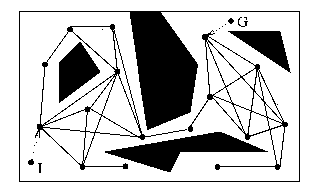

#### Rapidly Exploring Random Tree (RRT) and variants

Another Sampling is Rapidly Exploring Random Tree (RRT), which has a bias towards unexplored regions when creating new edges and exploring them. It is probabilistically complete, but the paths that are generated are often very suboptimal, as it will tend to zigzag alot (kind of like how modern American suburban neighborhoods with dead ends and cul-de-sacs tend to be hard to navigate). The figure below shows an example of a graph generated by a rapidly exploring random tree. 

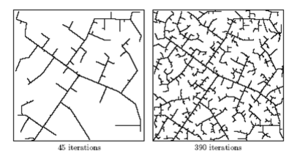

A variant of this algorithm, called RRT*, also rewires nodes in the graph at every step, choosing nearest neighbors to rewire. This allows for much more optimal solutions to be found, and is used in state-of-the-art robotic path planning algorithms even today. 

#### Team SKL: Saagar Sanghavi, Kevin Zhu, Tim Won
#### Credits 
When learning this material, we referred to UC Berkeley CS 188 and EE 106A. The sources used are the respective course lectures, course notes, and textbooks (*Artificial Intelligence, a Modern Approach* by Russell and Norvig, and *A Mathematical Introduction to Robotic Manipulation* by Murray, Li, and Sastry) 